# Introduction

The data below are readings from a NASA satellite device which detects temperature anomalies, which are instances where the temperature of a source is higher than its surroundings. The full data, along with other datasets, can be found at the following link.

https://www.kaggle.com/datasets/carlosparadis/fires-from-space-australia-and-new-zeland?select=fire_nrt_V1_96617.csv

Our objective is to explore these data, following the suggested Homework #1 from Andreas Mueller's course on Applied Machine Learning:

https://www.cs.columbia.edu/~amueller/comsw4995s20/schedule/

To begin, let's read the data from the csv file into a dataframe, and investigate the first few rows. 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv('fire_nrt_V1_96617.csv')
print(df.head())

   latitude  longitude  bright_ti4  scan  track    acq_date  acq_time  \
0 -42.69706  147.70634       333.6  0.57   0.43  2019-10-01       336   
1 -42.26889  147.31104       336.2  0.39   0.44  2019-10-01       336   
2 -40.85202  145.38068       327.9  0.46   0.47  2019-10-01       336   
3 -42.39329  147.47144       346.9  0.38   0.43  2019-10-01       336   
4 -42.69701  147.70584       334.1  0.56   0.43  2019-10-01       336   

  satellite instrument confidence version  bright_ti5  frp daynight  
0         N      VIIRS          n  1.0NRT       293.4  4.0        D  
1         N      VIIRS          n  1.0NRT       296.9  3.9        D  
2         N      VIIRS          n  1.0NRT       295.3  3.7        D  
3         N      VIIRS          n  1.0NRT       294.2  6.2        D  
4         N      VIIRS          n  1.0NRT       293.5  4.1        D  


As we can see, each reading has a number of features (14 to be exact), including latitude and longitude, referring to the 'center of the nominal 375m fire pixel.'

Let's see how many readings there are in total.

In [2]:
print(len(df))

956257


Wow! So there are nearly one million readings.

Next let's see over what time period these readings were taken. Our dataframe includes a 'acq_date' column, and we can use that information to see the time period. 

In [3]:
print(df.acq_date.min())
print(df.acq_date.max())

2019-10-01
2020-01-11


Okay, so we have data from Oct 1, 2019 until Jan 11, 2020, which is just over 3 months. 

# Task 1: Density Plots

1.1 Now let's see how the readings are distributed geographically. We will display a few plots, with latitude along the y-axis and longitude along the x-axis. 

1) First we will display a scatter plot of all points using the matplotlib default settings. As we will see, the marker size is so large that the information becomes very cluttered. 

2) To compensate for this, we can adjust the marker size (s) and increase the transparency (alpha) to get a better idea of the distribution. 

3) Perhaps an even better method is to use a hexbin plot, which counts all of the points lying within a certain hexagonal region, and then colors the regions according to their total counts. 

4) Finally, we also try randomly subsampling 10000 readings (or about 1% of the data) in a scatter plot with adjusted marker size and alpha to see if this helps us understand the distribution any better.   

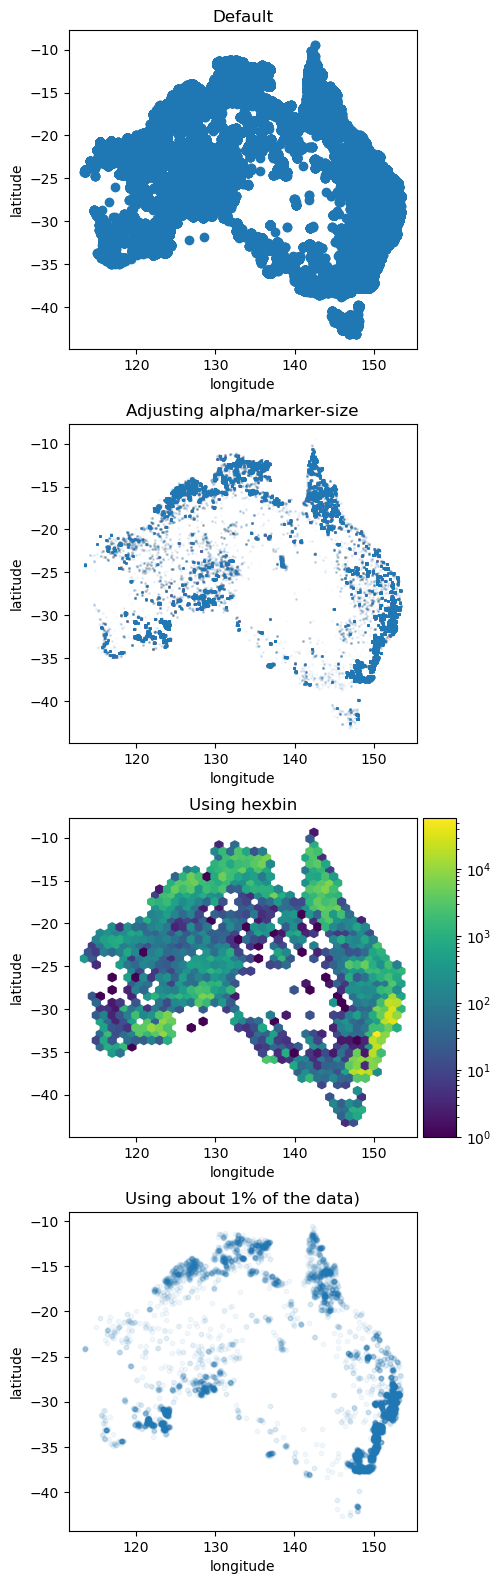

In [4]:
y = df.latitude
x = df.longitude
fig = plt.figure(figsize=(5,20)) 
gs = fig.add_gridspec(40, 10)
#Using default presets
ax1 = plt.subplot(gs[:9, :9])
ax1.scatter(x,y)
ax1.set_xlabel('longitude')
ax1.set_ylabel('latitude')
ax1.set_title('Default')
#Adjusting alpha and marker size
ax2 = plt.subplot(gs[10:19, :9])
ax2.scatter(x, y, alpha=0.01, s=1)
ax2.set_xlabel('longitude')
ax2.set_ylabel('latitude')
ax2.set_title('Adjusting alpha/marker-size')
#Using hexbin plot
ax3 = plt.subplot(gs[20:29, :9])
im = ax3.hexbin(x, y, gridsize=40, bins='log')
ax3.set_xlabel('longitude')
ax3.set_ylabel('latitude')
ax3.set_title('Using hexbin')
ax4 = plt.subplot(gs[20:29, -1])
#Subsampling the data
sample = df.sample(10000, random_state=42)
xx = sample.longitude
yy = sample.latitude
ax5 = plt.subplot(gs[30:39, :9])
ax5.scatter(xx, yy, alpha=0.05, s=10)
ax5.set_xlabel('longitude')
ax5.set_ylabel('latitude')
ax5.set_title('Using about 1% of the data)')

fig.subplots_adjust(hspace=10)
fig.colorbar(im, cax=ax4)

At this point, it is clear that the readings are from Australia. We can already see this from the first plot, and that plot already displays that there are no readings in the central mideast region. The other three plots give us a better understanding of where the readings are most dense.  

# Task 2: Visualizing Class Membership

The dataframe also includes a 'bright_ti4' column, which corresponds to a brightness feature. According to NASA (https://www.earthdata.nasa.gov/learn/find-data/near-real-time/firms/viirs-i-band-375-m-active-fire-data), this feature is the 'VIIRS I-4 channel brightness temperature of the fire pixel measured in Kelvin.' Kelvin is the primary unit of temperature measurement in the International System of Units. A change of one Kelvin corresponds to a change of one degree of Celsius, though Kelvin is a shifted scale: 0 degrees Celsius (freezing) is 273.15 Kelvin. 

Below we plot a few histograms of the Kelvin temperature reading, using different numbers of bins to get a better idea of how the readings are distributed in terms of temperature. 

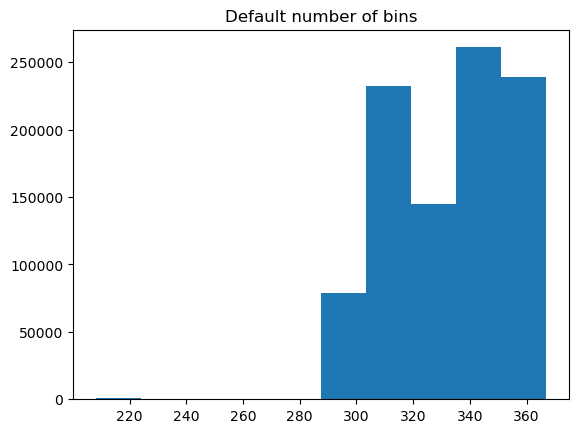

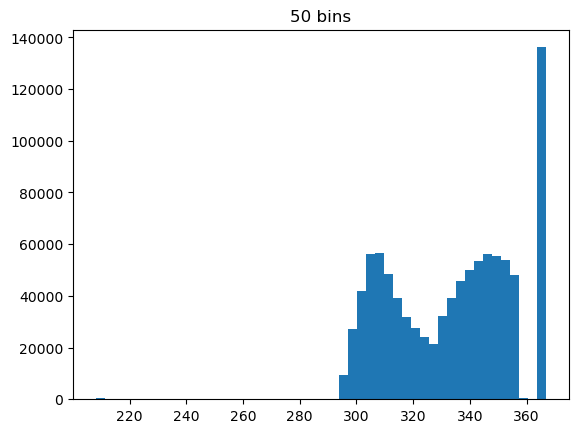

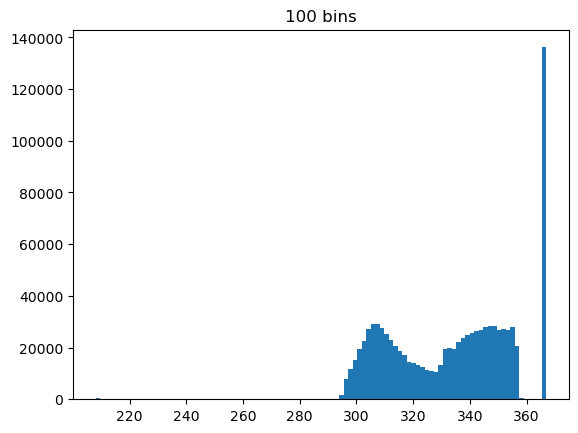

<Figure size 640x480 with 0 Axes>

In [5]:
plt.hist(df.bright_ti4)
plt.title('Default number of bins')
plt.show()
plt.clf()
plt.hist(df.bright_ti4, bins=50)
plt.title('50 bins')
plt.show()
plt.clf()
plt.hist(df.bright_ti4, bins=100)
plt.title('100 bins')
plt.show()
plt.clf()

Based on this histogram with 100 bins, we see that a large number of readings are being boxed into a bin at about 370 Kelvin. Because of this, we might assume that this bin represents a maximal or 'saturated' temperature reading, and the instrument cannot distinguish temperatures greater than this one. In addition, there is a gap below this bin, which suggests that those points belonging to this bin are in fact signficantly different than the others with lower temperatures. As a result of all this, we might reasonably say that those readings which are saturated do, in fact, correspond to fires. Other readings could also correspond to fires, but they might be smaller in area or just temperature anomalies of a different sort, such as a gas flare or the reflective roof of an industrial building. 

To better explore the saturated readings, let's separate our data into two classes: one for the saturated readings and one for the rest of the data. Then let's plot these distributions using hexbin plots, and see if we can discern any differences. 

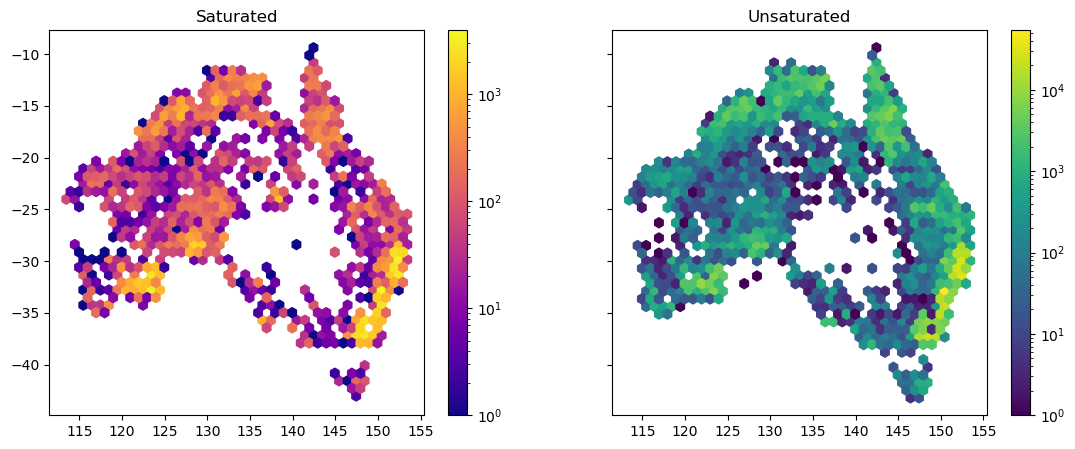

In [6]:
xs = df['longitude'][df.bright_ti4 > 360]
ys = df['latitude'][df.bright_ti4 > 360]
xu = df['longitude'][df.bright_ti4 < 360]
yu = df['latitude'][df.bright_ti4 < 360]

fig, axs = plt.subplots(ncols=2, sharey=True, sharex=True, figsize=(12, 5))
fig.subplots_adjust(hspace=0.5, left=0.07, right=0.93)
ax = axs[0]
hbs = ax.hexbin(xs, ys, gridsize=40, bins='log', cmap='plasma')
ax.set_title("Saturated")
cb = fig.colorbar(hbs, ax=ax)

ax = axs[1]
hbu = ax.hexbin(xu, yu, gridsize=40, bins='log', cmap='viridis')
ax.set_title("Unsaturated")
cb = fig.colorbar(hbu, ax=ax)

Based on these plots, the frequencies seem to be roughly similarly distributed. One noticeable difference is that the saturated class is not as frequent as the unsaturated class: the maximum values on the colorbars differ by about one order of magnitude.      

Another way we could try to compare the two distributions is by plotting both groups in the same axes with different colors. We can even try changing the order of plotting the two classes (i.e. draw the saturated first then the non-saturated or the other way around) to see if this helps. 

Text(0.5, 1.0, 'Unsatd. then Satd.')

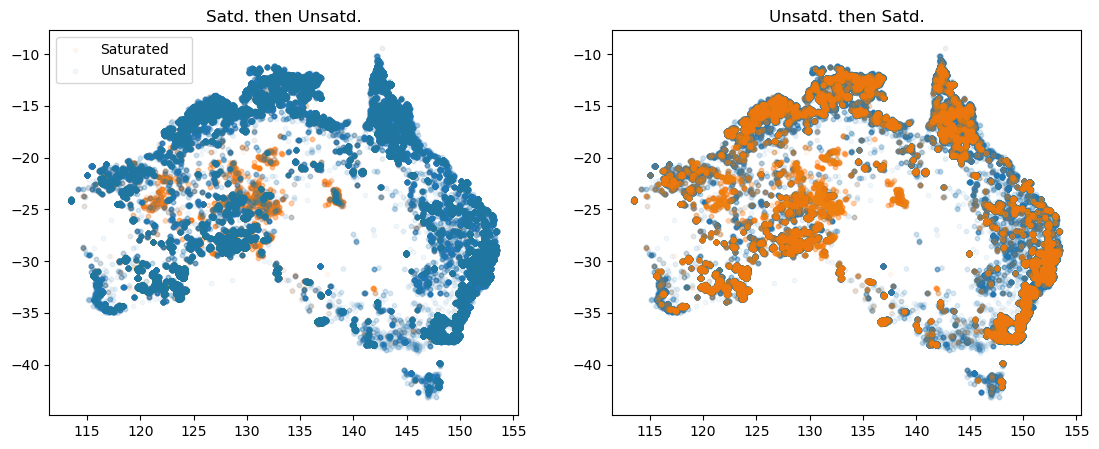

In [7]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
fig.subplots_adjust(left=0.07, right=0.93)
ax = axs[0]
scs = ax.scatter(xs, ys, alpha=0.05, s=10, color='C1', label='Saturated')
scu = ax.scatter(xu, yu, alpha=0.05, s=10, color='C0', label='Unsaturated')
ax.set_title('Satd. then Unsatd.')
ax.legend()

ax = axs[1]
scu = ax.scatter(xu, yu, alpha=0.05, s=10, color='C0')
scs = ax.scatter(xs, ys, alpha=0.05, s=10, color='C1')
ax.set_title('Unsatd. then Satd.')

On the left, we can see some areas where orange ('saturated') occurs with greater frequency, mostly in the middle of the continent. And on the right we can see that blue ('unsaturated') seems to dominate a little more along the coasts. 

One way we might obtain more information about the differences between the two distributions is by plotting the proportion of saturated readings. We have displayed this in a colored 2d histogram plot below.  

Text(0.5, 1.0, 'Proportion of Saturated readings')

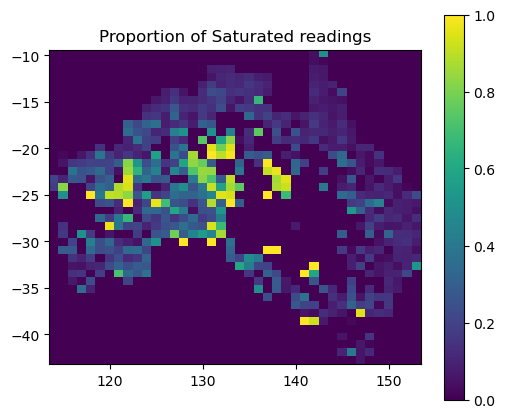

In [8]:
import numpy as np
Hs, xedges, yedges = np.histogram2d(xs, ys, bins=40)
Hs = Hs.T

Hu, xedgeu, yedgeu = np.histogram2d(xu, yu, bins=40)
Hu = Hu.T

Hsum = Hs + Hu
Hprop = np.divide(Hs, Hsum, out=np.zeros_like(Hsum), where=(Hsum!=0))

plt.figure(figsize=(6, 5))
plt.subplot(111)
plt.imshow(Hprop, interpolation='nearest', origin='lower',
        extent=[xedgeu[0], xedgeu[-1], yedgeu[0], yedgeu[-1]])
plt.colorbar()
plt.title('Proportion of Saturated readings')

We see a few areas, mostly in the center, where there is a much higher proportion of 'saturated' readings. 

In addition, here is another method of comparison, which is similar to hexbin plot, but displays a scatter plot, where each point is colored by its density (of nearby points). We have ensured that the points in the most dense areas are plotted last, so that they rise to the front of the figure.   

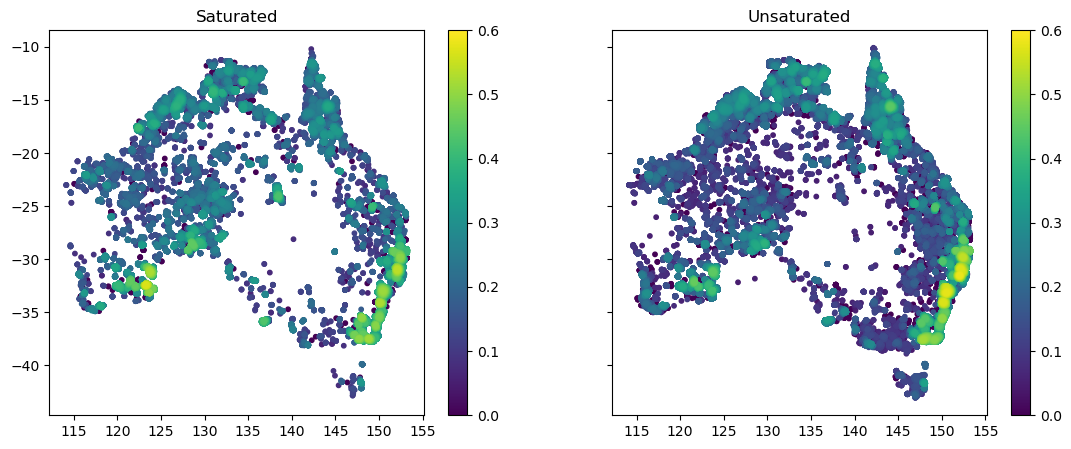

In [9]:
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

bins = 100

xs = np.array(xs)
ys = np.array(ys)
xu = np.array(xu)
yu = np.array(yu)

datas, xs_e, ys_e = np.histogram2d(xs, ys, bins = bins, density = True)
zs = interpn((0.5*(xs_e[1:] + xs_e[:-1]) , 0.5*(ys_e[1:]+ys_e[:-1])) , datas, np.vstack([xs,ys]).T , method = "splinef2d", bounds_error = False)
zs[zs<0] = 0
zs = np.power(zs, .25)
idxs = zs.argsort()

xs, ys, zs = xs[idxs], ys[idxs], zs[idxs]

datau, xu_e, yu_e = np.histogram2d(xu, yu, bins = bins, density = True)
zu = interpn((0.5*(xu_e[1:] + xu_e[:-1]) , 0.5*(yu_e[1:]+yu_e[:-1])) , datau, np.vstack([xu,yu]).T , method = "splinef2d", bounds_error = False)
zu[zu<0] = 0
zu = np.power(zu, .25)
idxu = zu.argsort()
xu, yu, zu = xu[idxu], yu[idxu], zu[idxu]


fig, axs = plt.subplots(ncols=2, sharey=True, sharex=True, figsize=(12, 5))
fig.subplots_adjust(left=0.07, right=0.93)
ax = axs[0]
sc = ax.scatter(xs, ys, c=zs, s=10, vmin=0, vmax=0.6)
ax.set_title("Saturated")
cb = fig.colorbar(sc, ax=ax)

ax = axs[1]
sc = ax.scatter(xu, yu, c=zu, s=10, vmin=0, vmax=0.6)
ax.set_title("Unsaturated")
cb = fig.colorbar(sc, ax=ax)

There are a number of other features in this dataset which might be interesting to explore, including a binary variable 'daynight' which indicates whether the reading occurred during the day or the night.   